/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/759017498.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='H')


缺失值数量: 3631 / 55176
缺失率: 6.58%


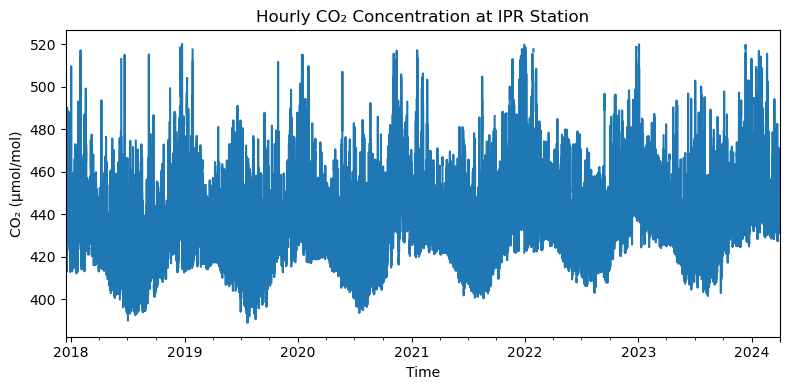

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据（跳过文件前45行注释）
file_path = 'ICOS_ATC_L2_L2-2024.1_IPR_40.0_CTS.txt'
df = pd.read_csv(file_path, sep=';', skiprows=44)

# 2. 构建时间戳列
df['datetime'] = pd.to_datetime(dict(
    year=df.Year, month=df.Month, day=df.Day, hour=df.Hour
))

# 3. 按时间排序并设置为索引
df = df.sort_values('datetime').set_index('datetime')

# 4. 筛选有效数据（CO2 ≠ -999.99 且 Flag 为 'O'）
df = df[(df['co2'] != -999.99) & (df['Flag'].str.strip() == 'O')]

# 5. 保留关键列
df_clean = df[['co2', 'Stdev', 'NbPoints']].copy()


# ==== 缺失率计算部分 ====
# 生成完整的时间索引（以小时为频率）
full_index = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='H')

# 重新索引，缺失点会填 NaN
df_full = df_clean.reindex(full_index)

# 计算缺失比例
missing_count = df_full['co2'].isna().sum()
total_count = len(df_full)
missing_percent = missing_count / total_count * 100

print(f"缺失值数量: {missing_count} / {total_count}")
print(f"缺失率: {missing_percent:.2f}%")

# 6. 可视化趋势（带缺失）
df_full['co2'].plot(figsize=(8, 4), title='Hourly CO₂ Concentration at IPR Station')
plt.ylabel('CO₂ (µmol/mol)')
plt.xlabel('Time')
# plt.grid(True)
plt.tight_layout()
plt.show()



In [2]:
import numpy as np
import pandas as pd

# 假设 df 已经有 datetime 索引，目标列是 'co2'
df_base = df.copy()

# 确保时间索引连续（小时）
df_base = df_base.asfreq("H")
y = df_base['co2'].copy()

# 1) 小缺口插值
y = y.interpolate(method='time', limit=6)

# 2) 对于大缺口，再做一次双向插值（保证全覆盖）
y = y.interpolate(method='time', limit_direction='both')

# 3) 最后兜底：如果还有 NaN，用前向填充再后向填充
y = y.fillna(method='ffill').fillna(method='bfill')

print("缺失值剩余数量:", y.isna().sum())


# 划分训练集和测试集（例如最后7天作为测试）
train_size = -24*7
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print(f"训练样本数: {len(y_train)}, 测试样本数: {len(y_test)}")


缺失值剩余数量: 0
训练样本数: 55008, 测试样本数: 168


/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/4067940442.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_base = df_base.asfreq("H")
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/4067940442.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill').fillna(method='bfill')


In [3]:
# 预测 = 前 24 小时的值
h = len(y_test)
y_pred_sn = y_train.shift(24).iloc[-h:]

# 对齐索引
y_pred_sn.index = y_test.index

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_sn = mean_absolute_error(y_test, y_pred_sn)
rmse_sn = mean_squared_error(y_test, y_pred_sn, squared=False)
mape_sn = (np.abs((y_test - y_pred_sn)/y_test)).mean()*100

print("\n=== Seasonal Naive ===")
print(f"MAE={mae_sn:.3f}, RMSE={rmse_sn:.3f}, MAPE={mape_sn:.2f}%")



=== Seasonal Naive ===
MAE=12.248, RMSE=16.044, MAPE=2.79%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train, order=(1,0,1), seasonal_order=(1,1,1,24),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

fc = res.get_forecast(steps=len(y_test))
y_pred_arima = fc.predicted_mean

mae_arima = mean_absolute_error(y_test, y_pred_arima)
rmse_arima = mean_squared_error(y_test, y_pred_arima, squared=False)
mape_arima = (np.abs((y_test - y_pred_arima)/y_test)).mean()*100

print("\n=== SARIMAX ===")
print(f"MAE={mae_arima:.3f}, RMSE={rmse_arima:.3f}, MAPE={mape_arima:.2f}%")



=== SARIMAX ===
MAE=7.644, RMSE=9.408, MAPE=1.73%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
# === GRU（直接预测序列，不学残差） ===
import numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 0) 标准化（只用训练集统计量）
y_mean, y_std = y_train.mean(), y_train.std()
if y_std == 0 or np.isnan(y_std):
    y_std = 1.0

y_train_n = ((y_train - y_mean) / y_std).astype(np.float32)
y_test_n  = ((y_test  - y_mean) / y_std).astype(np.float32)

# 1) 序列数据集（单步预测）
class SeqDS(Dataset):
    def __init__(self, series: pd.Series, seq_len=48):
        self.x = series.values.astype(np.float32)
        self.L = seq_len
    def __len__(self):
        return len(self.x) - self.L
    def __getitem__(self, i):
        xi = torch.tensor(self.x[i:i+self.L]).unsqueeze(-1)  # [L,1]
        yi = torch.tensor(self.x[i+self.L])                  # 标量
        return xi, yi

seq_len    = 48          # 上下文窗口
batch_size = 128
epochs     = 50          # 多跑一些；可调到 80
hidden     = 64

train_ds = SeqDS(y_train_n, seq_len)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

# 2) GRU 模型
class GRUReg(nn.Module):
    def __init__(self, hidden=64, layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(1, hidden, num_layers=layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
        self.fc  = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.gru(x)         # [B,L,H]
        out = self.fc(out[:, -1, :]) # 取最后一步
        return out.squeeze(-1)       # [B]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)

net   = GRUReg(hidden=hidden, layers=1).to(device)
opt   = torch.optim.Adam(net.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)
lossf = nn.MSELoss()

# 3) 训练
best, bad, patience = float('inf'), 0, 10
for ep in range(1, epochs+1):
    net.train(); run = 0.0; n = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = net(xb)
        loss = lossf(pred, yb)
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()
        run += loss.item() * len(xb); n += len(xb)
    run /= max(n,1)
    sched.step(run)
    print(f"[GRU] Epoch {ep:02d}/{epochs}  trainMSE={run:.5f}  lr={opt.param_groups[0]['lr']:.1e}")
    if run < best - 1e-6:
        best_state = {k:v.cpu().clone() for k,v in net.state_dict().items()}
        best, bad = run, 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping."); break

# 恢复最佳参数
net.load_state_dict({k:v.to(device) for k,v in best_state.items()})
net.eval()

# 4) 测试集逐步 walk-forward 预测（每步拿到真值再进入下一步；无未来泄漏）
buf = y_train_n.values[-seq_len:].tolist()
preds_n = []
with torch.no_grad():
    for t in range(len(y_test_n)):
        x = torch.tensor(buf[-seq_len:], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(-1)
        yhat_n = net(x).item()
        preds_n.append(yhat_n)

        # 关键区别：加入“刚刚观测到的真实标准化值”作为下一步输入
        buf.append(y_test_n.iloc[t])


# 5) 反标准化
y_pred_gru = pd.Series(np.array(preds_n)*y_std + y_mean, index=y_test.index, name='y_pred_gru')

# 6) 评估
mae_gru  = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = mean_squared_error(y_test, y_pred_gru, squared=False)
mape_gru = (np.abs((y_test - y_pred_gru)/y_test)).mean()*100

print("\n=== GRU（直接预测序列）===")
print(f"MAE={mae_gru:.3f}, RMSE={rmse_gru:.3f}, MAPE={mape_gru:.2f}%")

#（可选）可视化
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,3))
# plt.plot(y_test.index, y_test.values, label='True')
# plt.plot(y_pred_gru.index, y_pred_gru.values, label='GRU')
# plt.legend(); plt.title("GRU 直接预测（标准化+递归）"); plt.tight_layout(); plt.show()


[GRU] Epoch 01/50  trainMSE=0.18837  lr=1.0e-03
[GRU] Epoch 02/50  trainMSE=0.10808  lr=1.0e-03
[GRU] Epoch 03/50  trainMSE=0.10653  lr=1.0e-03
[GRU] Epoch 04/50  trainMSE=0.10536  lr=1.0e-03
[GRU] Epoch 05/50  trainMSE=0.10277  lr=1.0e-03
[GRU] Epoch 06/50  trainMSE=0.10064  lr=1.0e-03
[GRU] Epoch 07/50  trainMSE=0.09960  lr=1.0e-03
[GRU] Epoch 08/50  trainMSE=0.09871  lr=1.0e-03
[GRU] Epoch 09/50  trainMSE=0.09822  lr=1.0e-03
[GRU] Epoch 10/50  trainMSE=0.09737  lr=1.0e-03
[GRU] Epoch 11/50  trainMSE=0.09678  lr=1.0e-03
[GRU] Epoch 12/50  trainMSE=0.09653  lr=1.0e-03
[GRU] Epoch 13/50  trainMSE=0.09602  lr=1.0e-03
[GRU] Epoch 14/50  trainMSE=0.09611  lr=1.0e-03
[GRU] Epoch 15/50  trainMSE=0.09602  lr=1.0e-03
[GRU] Epoch 16/50  trainMSE=0.09573  lr=1.0e-03
[GRU] Epoch 17/50  trainMSE=0.09574  lr=1.0e-03
[GRU] Epoch 18/50  trainMSE=0.09567  lr=1.0e-03
[GRU] Epoch 19/50  trainMSE=0.09521  lr=1.0e-03
[GRU] Epoch 20/50  trainMSE=0.09512  lr=1.0e-03
[GRU] Epoch 21/50  trainMSE=0.09519  lr=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
# 汇总三模型指标（把你实际的数值填进来）
metrics = {
    "SeasonalNaive": {"MAE": 12.25, "RMSE": 16.04, "MAPE(%)": 2.79},
    "SARIMAX"        : {"MAE":  7.64, "RMSE":  9.41, "MAPE(%)": 1.73},
    "GRU"          : {"MAE":  2.952,"RMSE":  4.504,"MAPE(%)": 0.66},
}

# 计算相对改进（相对于 Naive 和 ARIMA）
for base in ["SeasonalNaive", "SARIMAX"]:
    print(f"\n=== 相对于 {base} 的改进（降低为正） ===")
    for k in ["MAE", "RMSE", "MAPE(%)"]:
        b = metrics[base][k]; g = metrics["GRU"][k]
        rel = (b - g) / b * 100
        print(f"{k}: {b:.3f} → {g:.3f} | 改进 {rel:.1f}%")

# （可选）可视化对比：真实值 vs 三模型预测（若你已有 y_pred_*）
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,4))
# plt.plot(y_test.index, y_test.values, label="True", linewidth=1.5)
# plt.plot(y_test.index, y_pred_sn.values, label="SeasonalNaive", alpha=0.8)
# plt.plot(y_test.index, y_pred_arima.values, label="ARIMA", alpha=0.8)
# plt.plot(y_test.index, y_pred_gru.values, label="GRU", alpha=0.9)
# plt.legend(); plt.title("Baseline 对比"); plt.tight_layout(); plt.show()



=== 相对于 SeasonalNaive 的改进（降低为正） ===
MAE: 12.250 → 2.952 | 改进 75.9%
RMSE: 16.040 → 4.504 | 改进 71.9%
MAPE(%): 2.790 → 0.660 | 改进 76.3%

=== 相对于 SARIMAX 的改进（降低为正） ===
MAE: 7.640 → 2.952 | 改进 61.4%
RMSE: 9.410 → 4.504 | 改进 52.1%
MAPE(%): 1.730 → 0.660 | 改进 61.8%


/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_ano = df.copy().asfreq('H')



=== 异常检测完成 ===
- 样本数: 55176
- 异常点数: 6465
- 异常占比(%): 11.717
- 参数: STL period=24, z阈值=4.0, IF contamination=0.01
- 前10个异常时间点: 2017-12-15 00:00:00, 2017-12-15 01:00:00, 2017-12-15 02:00:00, 2017-12-15 03:00:00, 2017-12-15 08:00:00, 2017-12-15 09:00:00, 2017-12-15 10:00:00, 2017-12-15 11:00:00, 2017-12-15 20:00:00, 2017-12-15 21:00:00
- 按小时异常率(%)（0-23时）： {0: 19.05, 1: 18.83, 2: 19.62, 3: 18.7, 4: 19.01, 5: 19.49, 6: 16.62, 7: 13.96, 8: 11.22, 9: 8.31, 10: 5.96, 11: 5.13, 12: 4.09, 13: 3.96, 14: 4.05, 15: 4.61, 16: 5.48, 17: 5.39, 18: 6.0, 19: 8.57, 20: 12.14, 21: 15.01, 22: 17.88, 23: 18.14}


/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:81: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:81: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:81: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:81: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1381921577.py:81: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans

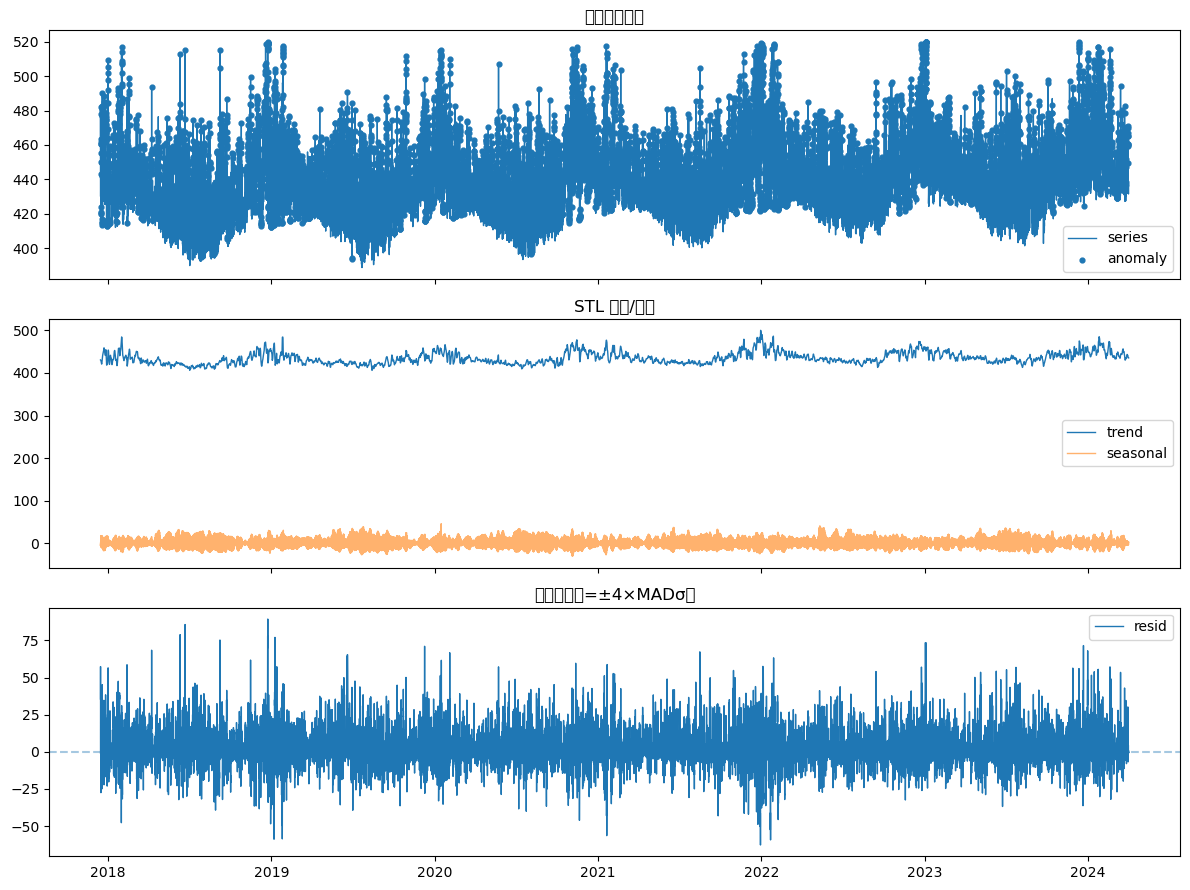

In [7]:
# === Step: 异常检测（STL残差 + IsolationForest）===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL

PLOT = True  # 想看图改 True

# 0) 取序列（保证小时频率 & 处理缺失以便可分解）
df_ano = df.copy().asfreq('H')

# 清理哨兵值（只对数值列）
num_cols = df_ano.select_dtypes(include='number').columns
df_ano[num_cols] = df_ano[num_cols].replace({-999.990: np.nan, -9.990: np.nan})

y_raw = df_ano['co2'].astype(float)

# 小缺口插值（<=6h），并记录仍然缺失的大缺口
y_step = y_raw.interpolate('time', limit=6)
large_gap = y_step.isna()

# STL 需要没有 NaN，这里用前后向兜底，但后续在判异常时会排除这些大缺口点
y_for_stl = y_step.ffill().bfill()

# 1) STL 分解（按日周期 24h）
stl = STL(y_for_stl, period=24, robust=True)
stl_res = stl.fit()
trend    = pd.Series(stl_res.trend,    index=y_for_stl.index, name='trend')
seasonal = pd.Series(stl_res.seasonal, index=y_for_stl.index, name='seasonal')
resid    = pd.Series(stl_res.resid,    index=y_for_stl.index, name='resid')

# 2) 残差 robust z-score
mad = float(np.abs(resid - resid.median()).median()) + 1e-9
z = (resid - resid.median()) / (1.4826 * mad)
anom_z = (np.abs(z) > 4.0)

# 3) Isolation Forest（基于 原值 + 残差；训练时排除大缺口点）
X = np.column_stack([y_for_stl.values, resid.values])
valid = ~large_gap.values
iforest = IsolationForest(n_estimators=300, contamination=0.01, random_state=42)
iforest.fit(X[valid])
pred_if_valid = (iforest.predict(X[valid]) == -1)
anom_if = np.zeros_like(valid, dtype=bool); anom_if[valid] = pred_if_valid

# 4) 合并判定 & 排除大缺口
anomaly = pd.Series((anom_z.values | anom_if) & (~large_gap.values),
                    index=y_for_stl.index, name='anomaly')

# 5) 打印摘要
n_total = len(y_for_stl)
n_anom  = int(anomaly.sum())
print("\n=== 异常检测完成 ===")
print(f"- 样本数: {n_total}")
print(f"- 异常点数: {n_anom}")
print(f"- 异常占比(%): {100*n_anom/n_total:.3f}")
print(f"- 参数: STL period=24, z阈值=4.0, IF contamination=0.01")
if n_anom > 0:
    preview = ', '.join(str(ts) for ts in anomaly[anomaly].index[:10])
    print(f"- 前10个异常时间点: {preview}")

# （可选）简单诊断：按小时的异常率
rate_by_hour = anomaly.groupby(anomaly.index.hour).mean()*100
print("- 按小时异常率(%)（0-23时）：", {int(k): round(v,2) for k,v in rate_by_hour.items()})

# 6) 可视化
if PLOT:
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3,1, figsize=(12,9), sharex=True)

    axes[0].plot(y_for_stl.index, y_for_stl.values, lw=1, label='series')
    axes[0].scatter(anomaly[anomaly].index, y_for_stl[anomaly].values, s=12, label='anomaly')
    axes[0].legend(); axes[0].set_title("序列与异常点")

    axes[1].plot(trend.index, trend.values, lw=1, label='trend')
    axes[1].plot(seasonal.index, seasonal.values, lw=1, alpha=0.6, label='seasonal')
    axes[1].legend(); axes[1].set_title("STL 趋势/季节")

    axes[2].plot(resid.index, resid.values, lw=1, label='resid')
    axes[2].axhline(0, ls='--', alpha=0.4); axes[2].legend()
    axes[2].set_title("残差（阈值=±4×MADσ）")

    plt.tight_layout(); plt.show()


In [8]:
# === Step: 变点检测（基于 STL 趋势 trend） ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, ruptures as rpt

PLOT = False  # 想看图改 True

# 0) 取趋势序列（上一节已得到 trend）
s = trend.dropna()
model = "rbf"      # 非参数核，能抓均值/斜率等多种变化
min_size = 24*3    # 每段至少 3 天（小时数据）
penalty  = 8.0     # 惩罚项，越大越少变点

if len(s) < max(min_size*2, 72):
    print("\n[变点] 样本过短，暂不检测。len(s) =", len(s))
    cp_times = []
else:
    algo = rpt.Pelt(model=model, min_size=min_size).fit(s.values)
    bkps = algo.predict(pen=penalty)              # 断点的“段尾”位置（1-based，含末尾）
    # 映射到时间戳；去掉最后一个 len(s)
    cp_idx = [b-1 for b in bkps[:-1]]
    cp_times = [s.index[i] for i in cp_idx]

    # 1) 打印摘要
    print("\n=== 变点检测完成 ===")
    print(f"- 趋势样本数: {len(s)}")
    print(f"- 模型/参数: model={model}, min_size={min_size}h, penalty={penalty}")
    print(f"- 检测到的变点数: {len(cp_times)}")
    if len(cp_times) > 0:
        preview = [str(t) for t in cp_times[:10]]
        if len(cp_times) > 10: preview.append("...")
        print(f"- 前几个变点: {', '.join(preview)}")

    # 2) 分段统计（长度、均值、与前一段的均值跳变）
    seg_edges = [0] + cp_idx + [len(s)-1]
    seg_info = []
    for k in range(len(seg_edges)-1):
        a, b = seg_edges[k], seg_edges[k+1]            # [a..b]
        yk = s.iloc[a:b+1]
        # 线性趋势斜率（ppm/小时），用于观察斜率变更
        x = np.arange(len(yk))
        slope = np.polyfit(x, yk.values, 1)[0] if len(yk) >= 2 else 0.0
        seg_info.append({
            "start": s.index[a],
            "end":   s.index[b],
            "len_h": int(len(yk)),
            "len_d": round(len(yk)/24, 2),
            "mean":  float(yk.mean()),
            "slope_ppm_per_h": float(slope),
        })

    # 计算相邻分段的均值跳变 & 斜率变化
    jumps = []
    for k in range(1, len(seg_info)):
        dm = seg_info[k]["mean"] - seg_info[k-1]["mean"]
        ds = seg_info[k]["slope_ppm_per_h"] - seg_info[k-1]["slope_ppm_per_h"]
        jumps.append({"cp_time": cp_times[k-1], "Δmean": float(dm), "Δslope(ppm/h)": float(ds)})

    # 打印分段与最大跳变
    if seg_info:
        lens_d = [seg["len_d"] for seg in seg_info]
        print(f"- 分段数量: {len(seg_info)}  | 平均段长: {np.mean(lens_d):.2f} 天  | 中位段长: {np.median(lens_d):.2f} 天")
    if jumps:
        # 按绝对均值跳变排序，展示前5个
        top = sorted(jumps, key=lambda d: abs(d["Δmean"]), reverse=True)[:5]
        print("- 最大的均值跳变（前5个）:")
        for j in top:
            print(f"  • {j['cp_time']} | Δmean={j['Δmean']:.2f} ppm, Δslope={j['Δslope(ppm/h)']:.4f}")

    # （可选）可视化：趋势 + 变点 + 分段均值
    if PLOT:
        fig, ax = plt.subplots(figsize=(12,3))
        ax.plot(s.index, s.values, lw=1, label='trend')
        for t in cp_times:
            ax.axvline(t, ls='--', alpha=0.6)
        # 画每段均值
        for seg in seg_info:
            ax.hlines(seg["mean"], seg["start"], seg["end"], colors='C3', linestyles='-', linewidth=1.5, alpha=0.8)
        ax.set_title(f"趋势与变点（model={model}, penalty={penalty}）")
        ax.legend(loc='upper left')
        plt.tight_layout(); plt.show()



=== 变点检测完成 ===
- 趋势样本数: 55176
- 模型/参数: model=rbf, min_size=72h, penalty=8.0
- 检测到的变点数: 380
- 前几个变点: 2017-12-19 03:00:00, 2017-12-27 21:00:00, 2017-12-31 00:00:00, 2018-01-04 19:00:00, 2018-01-07 22:00:00, 2018-01-11 01:00:00, 2018-01-14 04:00:00, 2018-01-17 07:00:00, 2018-01-23 03:00:00, 2018-01-26 11:00:00, ...
- 分段数量: 381  | 平均段长: 6.08 天  | 中位段长: 4.42 天
- 最大的均值跳变（前5个）:
  • 2019-01-08 13:00:00 | Δmean=-36.14 ppm, Δslope=-0.1969
  • 2018-02-02 03:00:00 | Δmean=-36.07 ppm, Δslope=0.0026
  • 2019-01-27 22:00:00 | Δmean=-34.31 ppm, Δslope=0.1557
  • 2022-01-04 05:00:00 | Δmean=-33.21 ppm, Δslope=-0.1823
  • 2024-01-24 00:00:00 | Δmean=29.56 ppm, Δslope=0.0983


In [9]:
# === Step 0: 准备基础序列 y0 ===
import numpy as np, pandas as pd

df_base = df.copy().asfreq('H')  # 保证小时频率

# 清理哨兵值（-999.990 / -9.990）
num_cols = df_base.select_dtypes(include='number').columns
df_base[num_cols] = df_base[num_cols].replace({-999.990: np.nan, -9.990: np.nan})

# 取 co2 序列，并做缺失兜底
y0 = df_base['co2'].astype(float)
y0 = y0.interpolate('time', limit=6)           # 小缺口插值
y0 = y0.interpolate('time', limit_direction='both')  # 双向插值
y0 = y0.ffill().bfill()                        # 最后兜底

print("y0 准备完成，样本数:", len(y0), "缺失值数量:", y0.isna().sum())


y0 准备完成，样本数: 55176 缺失值数量: 0


/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/1820951124.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_base = df.copy().asfreq('H')  # 保证小时频率


In [10]:
# 基于 STL 残差的 |z| 构造“软权重”：越异常权重越小
# 你前面已经有 z（robust z-score），如果没有就用 resid 重新算一下 z
tau = 3.0   # 控制压缩强度（越小，降权越狠）
p   = 2.0   # 曲线形状
w_min = 0.2 # 最小权重，避免完全忽略

z_abs = np.abs(z)  # z 来自异常检测那步
w_soft = 1.0 / (1.0 + (z_abs / tau) ** p)
w_soft = np.clip(w_soft, w_min, 1.0)      # ∈[w_min,1]
w_soft[~np.isfinite(w_soft)] = w_min

# 训练/测试对齐
w_train = w_soft.loc[y0.index].iloc[:-24*7]
w_test  = w_soft.loc[y0.index].iloc[-24*7:]
y_train = y0.iloc[:-24*7]
y_test  = y0.iloc[-24*7:]

print("\n=== 权重准备完成 ===")
print(f"- 训练集样本: {len(y_train)}, 测试集样本: {len(y_test)}")
print(f"- 训练集权重：min={w_train.min():.2f}, p25={w_train.quantile(0.25):.2f}, median={w_train.median():.2f}, max={w_train.max():.2f}")



=== 权重准备完成 ===
- 训练集样本: 55008, 测试集样本: 168
- 训练集权重：min=0.20, p25=0.81, median=0.95, max=1.00


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 构造时间/周末等外生特征（和之前一致，无需 regime）
exog_all = pd.DataFrame({
    'hour_sin': np.sin(2*np.pi*y0.index.hour/24),
    'hour_cos': np.cos(2*np.pi*y0.index.hour/24),
    'is_weekend': (pd.Series(y0.index.dayofweek, index=y0.index) >= 5).astype(int),
}, index=y0.index)

exog_tr = exog_all.iloc[:-24*7]
exog_te = exog_all.iloc[-24*7:]

# 训练序列：仅将异常点（或权重很低的点）置 NaN
y_train_w = y_train.copy()
mask_zero = anomaly.loc[y_train.index]  # 简单起见：异常点直接“0权重”
y_train_w[mask_zero] = np.nan

print("\n=== SARIMAX 加权训练（用缺测模拟权重=0）===")
print(f"- 被置为 NaN 的训练样本数: {int(mask_zero.sum())}")

model = SARIMAX(y_train_w, order=(1,0,1), seasonal_order=(1,1,1,24),
                exog=exog_tr, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

y_pred_ar_w = res.get_forecast(steps=len(y_test), exog=exog_te).predicted_mean
mae_ar_w  = mean_absolute_error(y_test, y_pred_ar_w)
rmse_ar_w = mean_squared_error(y_test, y_pred_ar_w, squared=False)
mape_ar_w = (np.abs((y_test - y_pred_ar_w)/y_test)).mean()*100
print(f"- SARIMAX(加权)  MAE={mae_ar_w:.3f} RMSE={rmse_ar_w:.3f} MAPE={mape_ar_w:.2f}%")



=== SARIMAX 加权训练（用缺测模拟权重=0）===
- 被置为 NaN 的训练样本数: 6444
- SARIMAX(加权)  MAE=7.002 RMSE=9.099 MAPE=1.58%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 标准化（只用训练集统计信息）
y_mean, y_std = y_train.mean(), y_train.std()
if not np.isfinite(y_std) or y_std == 0: y_std = 1.0
y_train_n = ((y_train - y_mean)/y_std).astype(np.float32)
y_test_n  = ((y_test  - y_mean)/y_std).astype(np.float32)

# 把目标权重也标准对齐（只是数值，权重本身不标准化）
class SeqWeightedDS(Dataset):
    def __init__(self, series: pd.Series, weights: pd.Series, L=48):
        self.x = series.values.astype(np.float32)
        self.w = weights.values.astype(np.float32)
        self.L = L
        assert len(self.x) == len(self.w)
    def __len__(self): return len(self.x) - self.L
    def __getitem__(self, i):
        xi = torch.tensor(self.x[i:i+self.L]).unsqueeze(-1)   # [L,1]
        yi = torch.tensor(self.x[i+self.L])                   # 标量
        wi = torch.tensor(self.w[i+self.L])                   # 目标对应时刻的权重
        return xi, yi, wi

seq_len=48; batch_size=128; epochs=60; hidden=64
train_ds = SeqWeightedDS(y_train_n, w_train, L=seq_len)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

class GRUReg(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.gru = nn.GRU(1, hidden, batch_first=True)
        self.fc  = nn.Linear(hidden, 1)
    def forward(self, x):
        y,_ = self.gru(x)
        return self.fc(y[:, -1, :]).squeeze(-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)
net = GRUReg(hidden=hidden).to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)

# Huber（SmoothL1）损失，逐样本再加权
huber = nn.SmoothL1Loss(reduction='none')

best=float('inf'); bad=0; patience=10
for ep in range(1, epochs+1):
    net.train(); run = 0.0; n = 0
    for xb, yb, wb in train_dl:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        pred = net(xb)
        loss_vec = huber(pred, yb)          # [B]
        loss_w   = (loss_vec * wb).mean()   # 加权平均
        opt.zero_grad(); loss_w.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()
        run += loss_w.item() * len(xb); n += len(xb)
    run /= max(n,1); sched.step(run)
    print(f"[GRU-w] Epoch {ep:02d}/{epochs}  trainLoss={run:.5f}")
    if run < best - 1e-6:
        best_state={k:v.cpu().clone() for k,v in net.state_dict().items()}
        best=run; bad=0
    else:
        bad+=1
        if bad>=patience:
            print("[GRU-w] early stop"); break

net.load_state_dict({k:v.to(device) for k,v in best_state.items()}); net.eval()

# walk-forward 评估（与之前一致）
buf = y_train_n.values[-seq_len:].tolist()
preds_n = []
with torch.no_grad():
    for t in range(len(y_test_n)):
        x = torch.tensor(buf[-seq_len:], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(-1)
        yhat_n = net(x).item()
        preds_n.append(yhat_n)
        buf.append(y_test_n.iloc[t])  # 用真实标准化值推进

y_pred_gru_w = pd.Series(np.array(preds_n)*y_std + y_mean, index=y_test.index)
mae_gru_w  = mean_absolute_error(y_test, y_pred_gru_w)
rmse_gru_w = mean_squared_error(y_test, y_pred_gru_w, squared=False)
mape_gru_w = (np.abs((y_test - y_pred_gru_w)/y_test)).mean()*100
print("\n=== GRU（加权+Huber）===")
print(f"- MAE={mae_gru_w:.3f} RMSE={rmse_gru_w:.3f} MAPE={mape_gru_w:.2f}%")


[GRU-w] Epoch 01/60  trainLoss=0.06010
[GRU-w] Epoch 02/60  trainLoss=0.03292
[GRU-w] Epoch 03/60  trainLoss=0.03207
[GRU-w] Epoch 04/60  trainLoss=0.03105
[GRU-w] Epoch 05/60  trainLoss=0.03006
[GRU-w] Epoch 06/60  trainLoss=0.02937
[GRU-w] Epoch 07/60  trainLoss=0.02916
[GRU-w] Epoch 08/60  trainLoss=0.02891
[GRU-w] Epoch 09/60  trainLoss=0.02872
[GRU-w] Epoch 10/60  trainLoss=0.02858
[GRU-w] Epoch 11/60  trainLoss=0.02844
[GRU-w] Epoch 12/60  trainLoss=0.02834
[GRU-w] Epoch 13/60  trainLoss=0.02817
[GRU-w] Epoch 14/60  trainLoss=0.02818
[GRU-w] Epoch 15/60  trainLoss=0.02814
[GRU-w] Epoch 16/60  trainLoss=0.02796
[GRU-w] Epoch 17/60  trainLoss=0.02803
[GRU-w] Epoch 18/60  trainLoss=0.02798
[GRU-w] Epoch 19/60  trainLoss=0.02789
[GRU-w] Epoch 20/60  trainLoss=0.02782
[GRU-w] Epoch 21/60  trainLoss=0.02790
[GRU-w] Epoch 22/60  trainLoss=0.02787
[GRU-w] Epoch 23/60  trainLoss=0.02781
[GRU-w] Epoch 24/60  trainLoss=0.02779
[GRU-w] Epoch 25/60  trainLoss=0.02768
[GRU-w] Epoch 26/60  trai

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# Robust Seasonal Naive: 避免直接用异常点
h = len(y_test)
pred_vals = []
for t in range(h):
    idx = y_test.index[t]
    ref_time = idx - pd.Timedelta(hours=24)
    if anomaly.loc[ref_time]:
        # 如果这个参照点是异常 → 用过去3天非异常点的中位数
        window = pd.date_range(end=ref_time, periods=24*3, freq='H')
        vals = y0.loc[window]
        vals = vals[~anomaly.loc[window]]
        val = vals.median() if len(vals) > 0 else y0.loc[ref_time]
    else:
        val = y0.loc[ref_time]
    pred_vals.append(val)

y_pred_sn_w = pd.Series(pred_vals, index=y_test.index, name='y_pred_sn_w')

mae_sn_w  = mean_absolute_error(y_test, y_pred_sn_w)
rmse_sn_w = mean_squared_error(y_test, y_pred_sn_w, squared=False)
mape_sn_w = (np.abs((y_test - y_pred_sn_w)/y_test)).mean()*100

print("\n=== Robust Seasonal Naive ===")
print(f"MAE={mae_sn_w:.3f}, RMSE={rmse_sn_w:.3f}, MAPE={mape_sn_w:.2f}%")



=== Robust Seasonal Naive ===
MAE=8.050, RMSE=11.087, MAPE=1.80%


/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/3182744235.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  window = pd.date_range(end=ref_time, periods=24*3, freq='H')
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

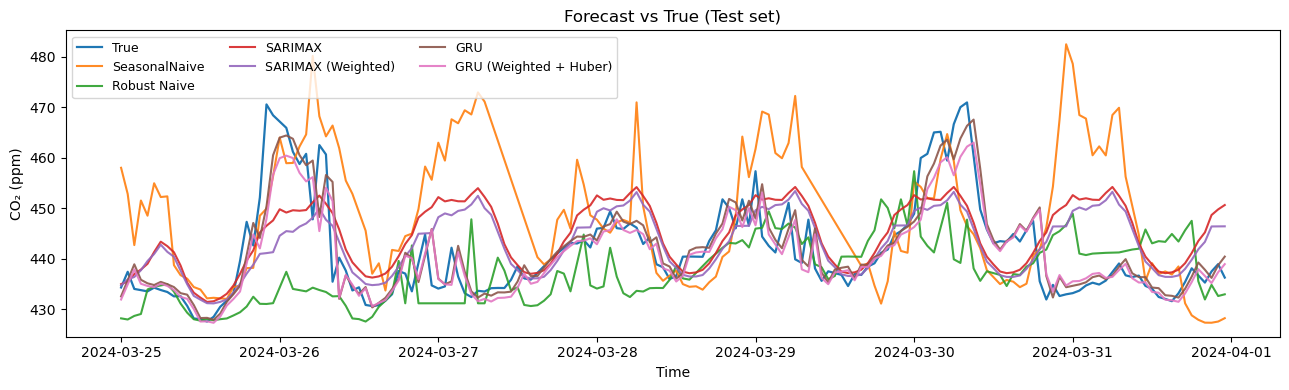

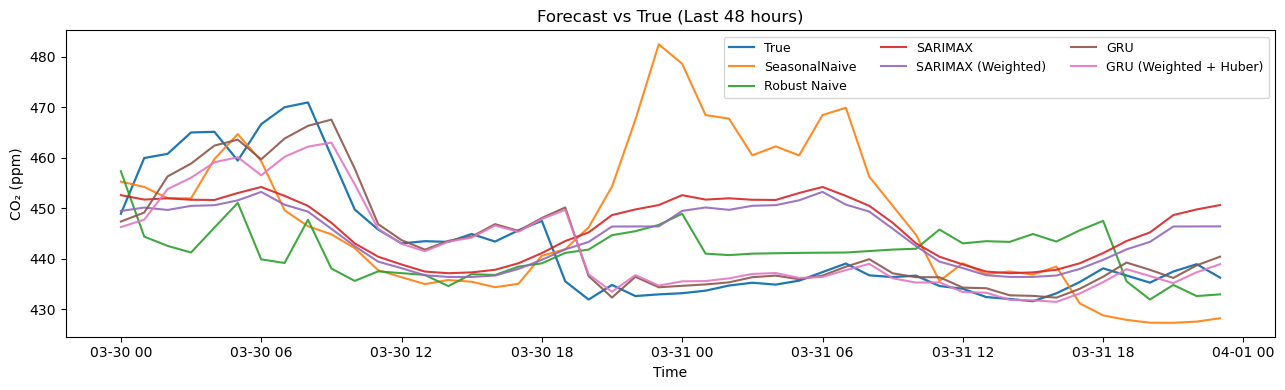

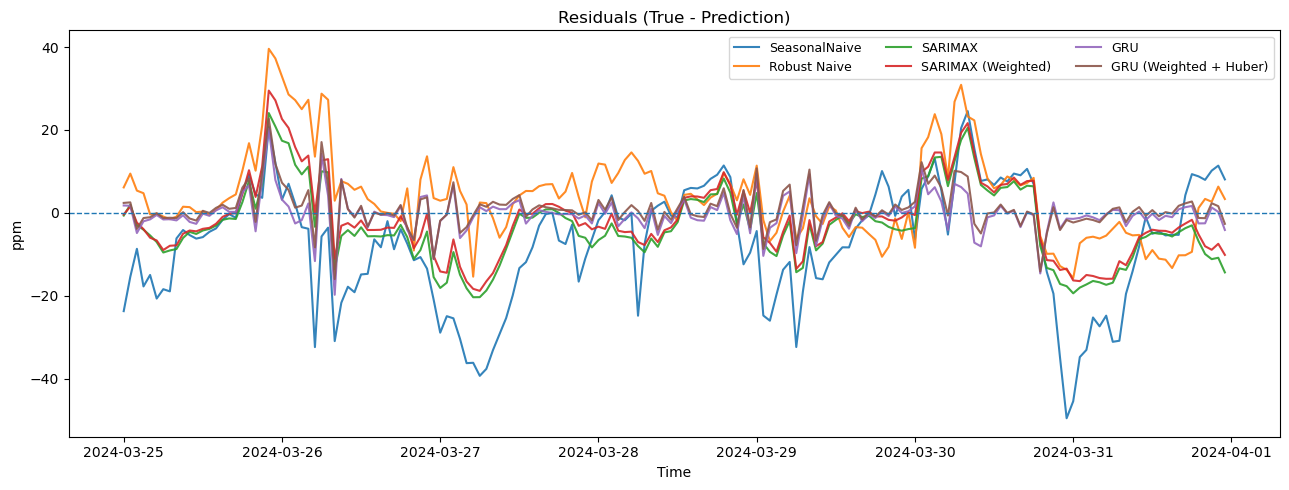

/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/2893183565.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].bar(names, MAE);  axes[0].set_title("MAE");  axes[0].set_xticklabels(names, rotation=20, ha='right')
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/2893183565.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].bar(names, RMSE); axes[1].set_title("RMSE"); axes[1].set_xticklabels(names, rotation=20, ha='right')
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_2546/2893183565.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].bar(names, MAPE); axes[2].set_title("MAPE (%)"); axes[2].set_xticklabels(names, rotation=20, ha='right')


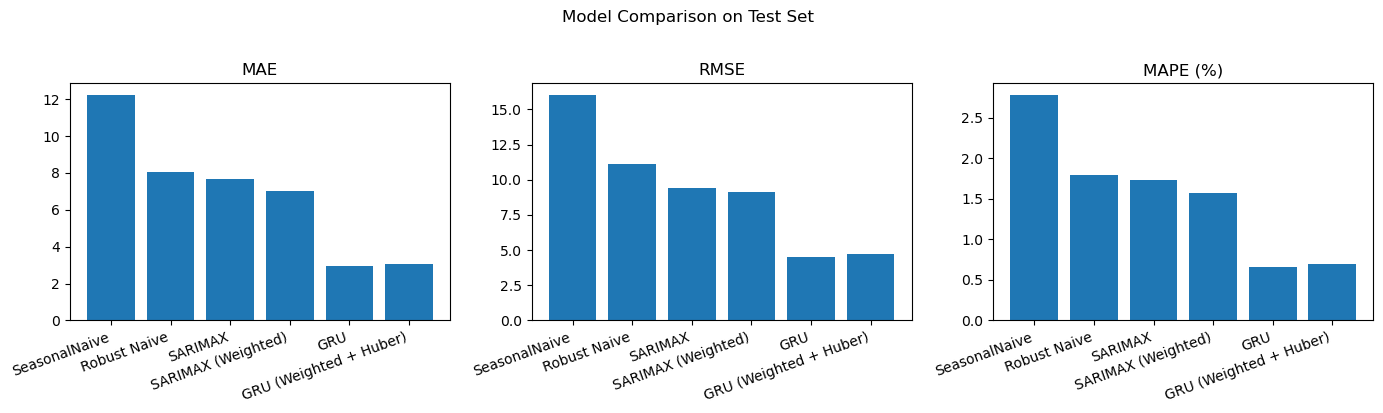


=== Metrics on Test Set ===
         SeasonalNaive | MAE= 12.248  RMSE= 16.044  MAPE= 2.79%
          Robust Naive | MAE=  8.050  RMSE= 11.087  MAPE= 1.80%
               SARIMAX | MAE=  7.644  RMSE=  9.408  MAPE= 1.73%
    SARIMAX (Weighted) | MAE=  7.002  RMSE=  9.099  MAPE= 1.58%
                   GRU | MAE=  2.952  RMSE=  4.504  MAPE= 0.66%
GRU (Weighted + Huber) | MAE=  3.087  RMSE=  4.748  MAPE= 0.69%


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ====== 1) 收集可用的预测 ======
# 这里按你前面用过的变量名来找；若有不同名字，可在 mapping 里补充
candidates = {
    "SeasonalNaive": "y_pred_sn",        # 原始 Naive（若没算过可以留空）
    "Robust Naive": "y_pred_sn_w",
    "SARIMAX":        "y_pred_arima",
    "SARIMAX (Weighted)": "y_pred_ar_w",
    "GRU":          "y_pred_gru",
    "GRU (Weighted + Huber)": "y_pred_gru_w",
}

preds = {}
for name, var in candidates.items():
    if var in globals():
        s = globals()[var]
        # 只取与 y_test 重叠的部分，避免因索引对不齐报错
        s = s.dropna()
        common = y_test.index.intersection(s.index)
        if len(common) > 0:
            preds[name] = s.loc[common]
# 对齐 y_test 到共同索引
if not preds:
    raise RuntimeError("没有找到可用的预测序列，请检查变量名。")
common_idx = y_test.index
for s in preds.values():
    common_idx = common_idx.intersection(s.index)
y_true = y_test.loc[common_idx]
preds = {k: v.loc[common_idx] for k, v in preds.items()}

# ====== 2) 指标计算（若已有人手算过也无妨，这里再算一遍以保证一致）======
def _metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean() * 100
    return mae, rmse, mape

metrics = {name: _metrics(y_true, yhat) for name, yhat in preds.items()}

# ====== 3) 图一：预测曲线对比（全测试集）======
plt.figure(figsize=(13,4))
plt.plot(y_true.index, y_true.values, label="True", linewidth=1.6)
for name, yhat in preds.items():
    plt.plot(yhat.index, yhat.values, label=name, alpha=0.9)
plt.title("Forecast vs True (Test set)")
plt.xlabel("Time"); plt.ylabel("CO₂ (ppm)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout(); plt.show()

# ====== 4) 图二：最近 48 小时放大图（可改 n_zoom）======
n_zoom = 48
idx_zoom = common_idx[-n_zoom:]
plt.figure(figsize=(13,4))
plt.plot(idx_zoom, y_true.loc[idx_zoom].values, label="True", linewidth=1.6)
for name, yhat in preds.items():
    plt.plot(idx_zoom, yhat.loc[idx_zoom].values, label=name, alpha=0.9)
plt.title(f"Forecast vs True (Last {n_zoom} hours)")
plt.xlabel("Time"); plt.ylabel("CO₂ (ppm)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout(); plt.show()

# ====== 5) 图三：残差对比（全测试集）======
plt.figure(figsize=(13,5))
for i, (name, yhat) in enumerate(preds.items(), start=1):
    res = (y_true - yhat)
    plt.plot(res.index, res.values, label=name, alpha=0.9)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals (True - Prediction)")
plt.xlabel("Time"); plt.ylabel("ppm")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout(); plt.show()

# ====== 6) 图四：指标柱状图（MAE/RMSE/MAPE）======
names = list(metrics.keys())
MAE  = [metrics[n][0] for n in names]
RMSE = [metrics[n][1] for n in names]
MAPE = [metrics[n][2] for n in names]

fig, axes = plt.subplots(1, 3, figsize=(14,4))
axes[0].bar(names, MAE);  axes[0].set_title("MAE");  axes[0].set_xticklabels(names, rotation=20, ha='right')
axes[1].bar(names, RMSE); axes[1].set_title("RMSE"); axes[1].set_xticklabels(names, rotation=20, ha='right')
axes[2].bar(names, MAPE); axes[2].set_title("MAPE (%)"); axes[2].set_xticklabels(names, rotation=20, ha='right')
fig.suptitle("Model Comparison on Test Set", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ====== 7) （可选）把指标打印为表格 ======
print("\n=== Metrics on Test Set ===")
for n in names:
    mae, rmse, mape = metrics[n]
    print(f"{n:>22s} | MAE={mae:7.3f}  RMSE={rmse:7.3f}  MAPE={mape:5.2f}%")


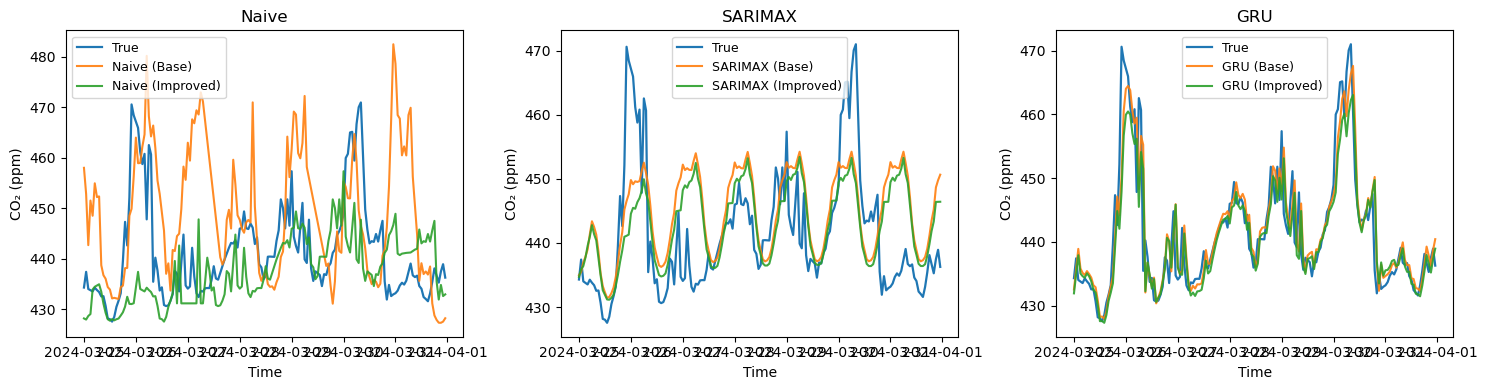

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

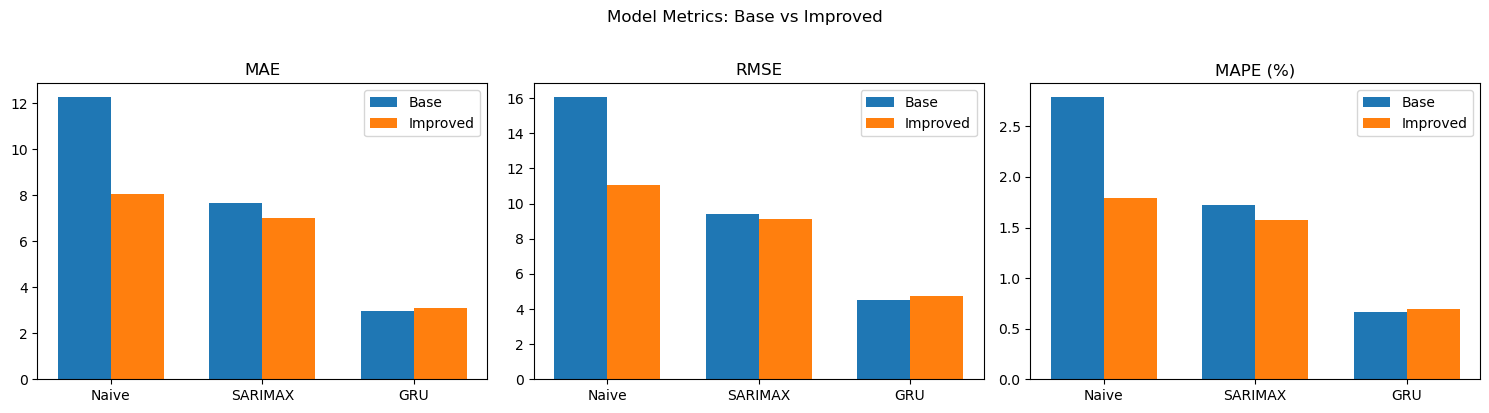

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ========= 1) 收集与对齐 =========
models = {
    "Naive":  ("y_pred_sn",    "y_pred_sn_w"),
    "SARIMAX":  ("y_pred_arima", "y_pred_ar_w"),
    "GRU":    ("y_pred_gru",   "y_pred_gru_w"),
}

def get_series(name):
    return globals()[name] if name in globals() else None

# 与 y_test 对齐；允许缺项（没算改进或没算基线某个也能画其它）
aligned = {}
for m, (base_name, imp_name) in models.items():
    base = get_series(base_name)
    imp  = get_series(imp_name)
    if base is None and imp is None:
        continue
    # 公共索引
    idx = y_test.index
    if base is not None:
        base = base.dropna()
        idx = idx.intersection(base.index)
    if imp is not None:
        imp = imp.dropna()
        idx = idx.intersection(imp.index)
    if len(idx) == 0:
        continue
    aligned[m] = {
        "true": y_test.loc[idx],
        "base": base.loc[idx] if base is not None else None,
        "imp":  imp.loc[idx]  if imp  is not None else None,
    }

if not aligned:
    raise RuntimeError("没有可对齐的数据。请检查变量名或确保预测已生成。")

# ========= 2) 线图：一行三列 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
axes = np.atleast_1d(axes)

for ax, m in zip(axes, ["Naive","SARIMAX","GRU"]):
    if m not in aligned:
        ax.axis("off")
        ax.set_title(f"{m}（无数据）")
        continue
    pack = aligned[m]
    ax.plot(pack["true"].index, pack["true"].values, label="True", linewidth=1.6)
    if pack["base"] is not None:
        ax.plot(pack["base"].index, pack["base"].values, label=f"{m} (Base)", alpha=0.9)
    if pack["imp"] is not None:
        ax.plot(pack["imp"].index,  pack["imp"].values,  label=f"{m} (Improved)", alpha=0.9)
    ax.set_title(m)
    ax.set_xlabel("Time")
    ax.set_ylabel("CO₂ (ppm)")
    ax.legend(fontsize=9)

# 若某些模型缺失，隐藏多余子图
for j in range(len(aligned), 3):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# ========= 3) 指标计算 =========
def _metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean() * 100
    return mae, rmse, mape

# 为每个模型计算 base/imp 两套（可能有缺项）
metric_table = {}
for m, pack in aligned.items():
    y_true = pack["true"]
    base_m = _metrics(y_true, pack["base"]) if pack["base"] is not None else (np.nan, np.nan, np.nan)
    imp_m  = _metrics(y_true, pack["imp"])  if pack["imp"]  is not None else (np.nan, np.nan, np.nan)
    metric_table[m] = {"base": base_m, "imp": imp_m}

# ========= 4) 柱状图：每个指标一个子图，模型分组，基线/改进并排 =========
models_order = [m for m in ["Naive","SARIMAX","GRU"] if m in metric_table]
n_groups = len(models_order)
bar_w = 0.35
x = np.arange(n_groups)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ["MAE", "RMSE", "MAPE (%)"]

for i, ax in enumerate(axes):
    base_vals = []
    imp_vals  = []
    for m in models_order:
        b = metric_table[m]["base"][i]
        v = metric_table[m]["imp"][i]
        base_vals.append(b)
        imp_vals.append(v)
    ax.bar(x - bar_w/2, base_vals, width=bar_w, label="Base")
    ax.bar(x + bar_w/2, imp_vals,  width=bar_w, label="Improved")
    ax.set_xticks(x)
    ax.set_xticklabels(models_order)
    ax.set_title(titles[i])
    ax.legend()
    # y 轴从 0 起更直观（MAPE 也一样）
    ax.set_ylim(bottom=0)

fig.suptitle("Model Metrics: Base vs Improved", y=1.02)
plt.tight_layout()
plt.show()


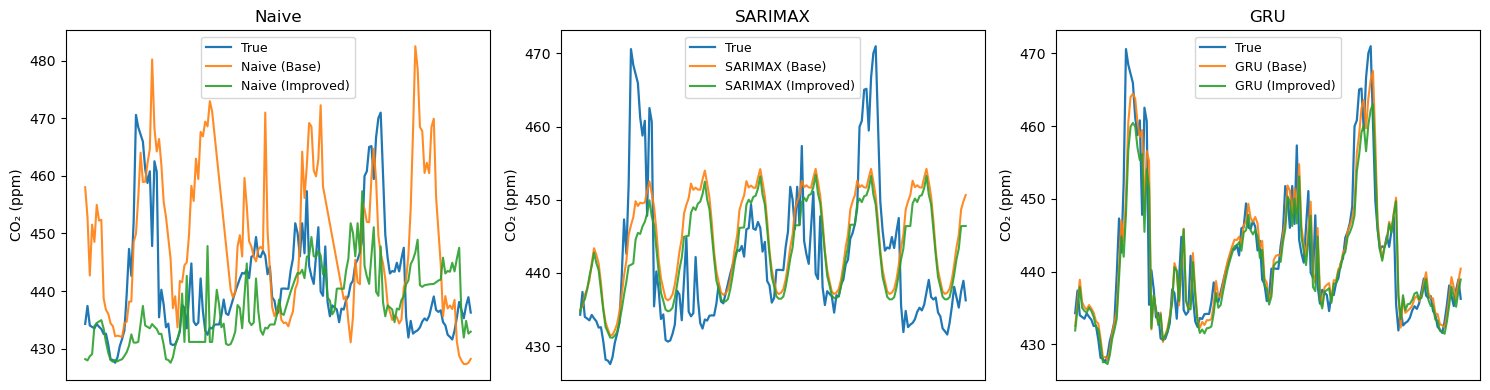

In [16]:
# ========= 2) 线图：一行三列 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
axes = np.atleast_1d(axes)

for ax, m in zip(axes, ["Naive","SARIMAX","GRU"]):
    if m not in aligned:
        ax.axis("off")
        ax.set_title(f"{m}（无数据）")
        continue
    pack = aligned[m]
    ax.plot(pack["true"].index, pack["true"].values, label="True", linewidth=1.6)
    if pack["base"] is not None:
        ax.plot(pack["base"].index, pack["base"].values, label=f"{m} (Base)", alpha=0.9)
    if pack["imp"] is not None:
        ax.plot(pack["imp"].index,  pack["imp"].values,  label=f"{m} (Improved)", alpha=0.9)
    ax.set_title(m)
    ax.set_ylabel("CO₂ (ppm)")
    ax.legend(fontsize=9)
    # 去掉横坐标刻度和标签
    ax.set_xticks([])
    ax.set_xlabel("")

# 隐藏多余子图
for j in range(len(aligned), 3):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


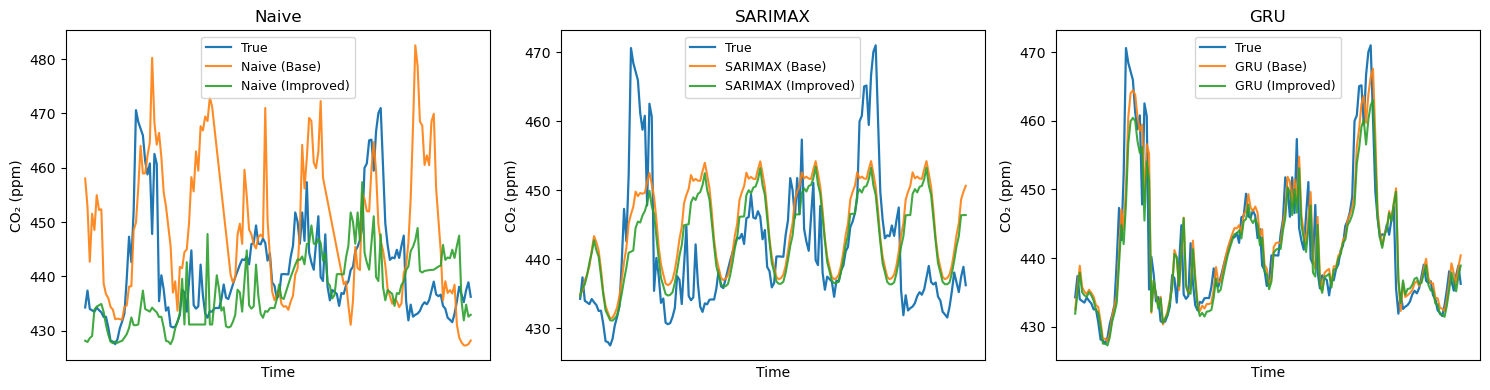

In [17]:
# ========= 2) 线图：一行三列 =========
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
axes = np.atleast_1d(axes)

for ax, m in zip(axes, ["Naive","SARIMAX","GRU"]):
    if m not in aligned:
        ax.axis("off")
        ax.set_title(f"{m}（无数据）")
        continue
    pack = aligned[m]
    ax.plot(pack["true"].index, pack["true"].values, label="True", linewidth=1.6)
    if pack["base"] is not None:
        ax.plot(pack["base"].index, pack["base"].values, label=f"{m} (Base)", alpha=0.9)
    if pack["imp"] is not None:
        ax.plot(pack["imp"].index,  pack["imp"].values,  label=f"{m} (Improved)", alpha=0.9)
    ax.set_title(m)
    ax.set_ylabel("CO₂ (ppm)")
    ax.legend(fontsize=9)
    # 去掉横坐标刻度，但保留横坐标标签
    ax.set_xticks([])
    ax.set_xlabel("Time")

# 隐藏多余子图
for j in range(len(aligned), 3):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SAVE_FIG = False  # True 则保存图片
OUTDIR   = "./figs"  # 保存目录


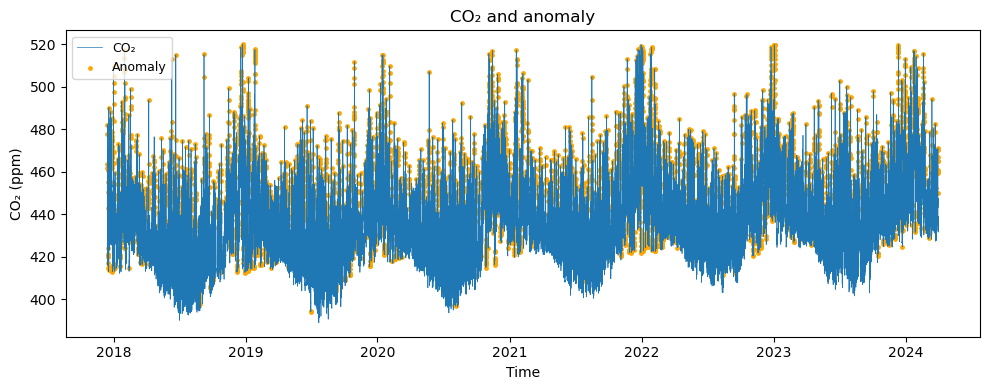

In [19]:
plt.figure(figsize=(10,4))
plt.plot(y0.index, y0.values, lw=0.5, label="CO₂")  # 更细的线
idx_anom = anomaly[anomaly].index
plt.scatter(
    idx_anom,
    y0.loc[idx_anom].values,
    s=6,                 # 点更小
    color="orange",      # 点的颜色设为橙色
    label="Anomaly"
)
plt.title("CO₂ and anomaly")
plt.ylabel("CO₂ (ppm)")
plt.xlabel("Time")
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
if SAVE_FIG:
    import os; os.makedirs(OUTDIR, exist_ok=True)
    plt.savefig(f"{OUTDIR}/anomaly_timeseries_full.png", dpi=300)
plt.show()



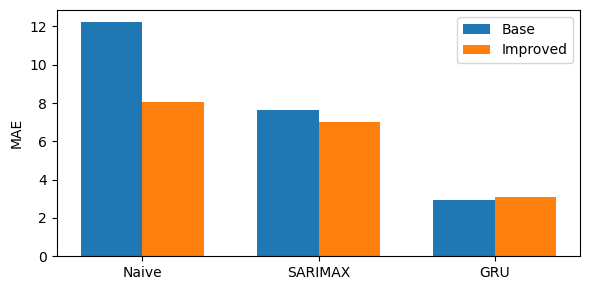

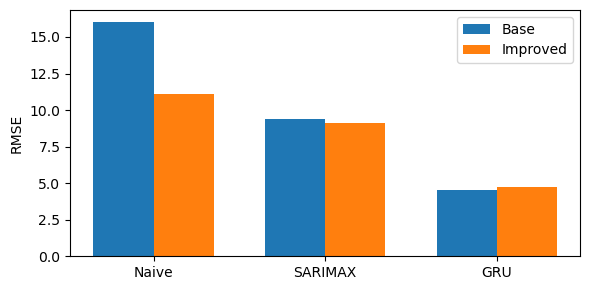

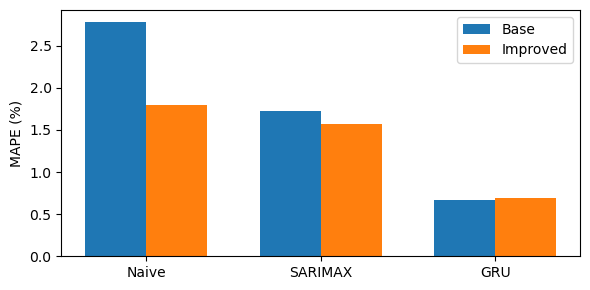

In [20]:
models_order = [m for m in ["Naive","SARIMAX","GRU"] if m in metric_table]
n_groups = len(models_order)
bar_w = 0.35
x = np.arange(n_groups)

titles = ["MAE", "RMSE", "MAPE (%)"]

for i in range(3):
    base_vals = []
    imp_vals  = []
    for m in models_order:
        b = metric_table[m]["base"][i]
        v = metric_table[m]["imp"][i]
        base_vals.append(b)
        imp_vals.append(v)
    
    plt.figure(figsize=(6,3))
    plt.bar(x - bar_w/2, base_vals, width=bar_w, label="Base")
    plt.bar(x + bar_w/2, imp_vals,  width=bar_w, label="Improved")
    plt.xticks(x, models_order)
    # plt.title(f"Model Metric: {titles[i]}")
    plt.ylabel(titles[i])
    plt.legend()
    plt.ylim(bottom=0)   # Y 轴从 0 起
    plt.tight_layout()
    plt.show()


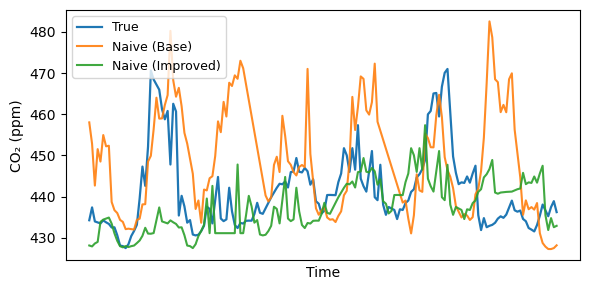

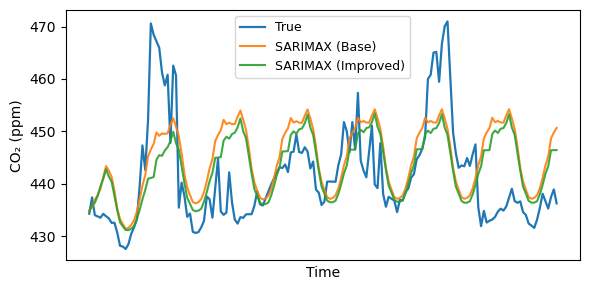

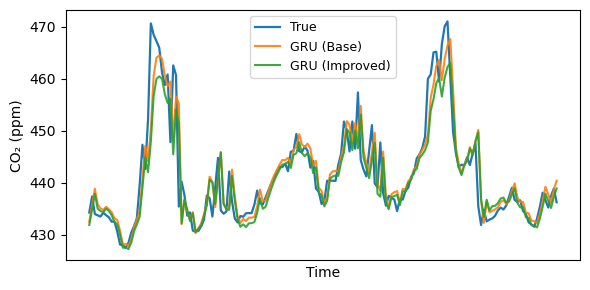

In [47]:
for m in ["Naive","SARIMAX","GRU"]:
    if m not in aligned:
        plt.figure(figsize=(6,3))
        plt.axis("off")
        plt.title(f"{m}（无数据）")
        plt.show()
        continue
    
    pack = aligned[m]
    plt.figure(figsize=(6,3))
    plt.plot(pack["true"].index, pack["true"].values, label="True", linewidth=1.6)
    if pack["base"] is not None:
        plt.plot(pack["base"].index, pack["base"].values, label=f"{m} (Base)", alpha=0.9)
    if pack["imp"] is not None:
        plt.plot(pack["imp"].index, pack["imp"].values, label=f"{m} (Improved)", alpha=0.9)
    
    # plt.title(m)
    plt.ylabel("CO₂ (ppm)")
    plt.xlabel("Time")
    plt.legend(fontsize=9)
    plt.xticks([])  # 去掉刻度但保留 xlabel
    plt.tight_layout()
    plt.show()


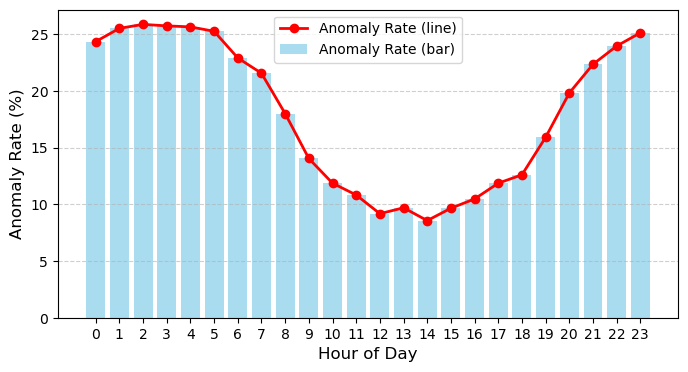

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
hours = np.arange(24)
anomaly_rate = [
    24.36, 25.53, 25.88, 25.75, 25.66, 25.27,
    22.92, 21.57, 18.01, 14.05, 11.87, 10.83,
     9.18,  9.70,  8.57,  9.66, 10.48, 11.87,
    12.61, 15.92, 19.83, 22.36, 23.97, 25.14
]

# 设置画布
plt.figure(figsize=(8,4))

# 条形图
plt.bar(hours, anomaly_rate, color="skyblue", alpha=0.7, label="Anomaly Rate (bar)")

# 折线图
plt.plot(hours, anomaly_rate, color="red", marker="o", linewidth=2, label="Anomaly Rate (line)")

# 坐标轴与标签
plt.xticks(hours)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Anomaly Rate (%)", fontsize=12)
# plt.title("Hourly Anomaly Rate (%)", fontsize=14, fontweight="bold")

# 网格与图例
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()

plt.show()
